# Training GPT2 124M on Tiny shakespeare dataset on my laptop

In this notebook, we train a GPT2 124M model on the Tiny Shakespeare dataset on my laptop without any optimizations.

In [1]:
from pathlib import Path

import torch
from matplotlib import pyplot as plt

from gollem.data import load_dataset
from gollem.models.gpt2.config import GPT2Config
from gollem.models.gpt2.config import get_gpt2_model_config
from gollem.train.config import TrainConfig
from gollem.train.core import run
from gollem.utils import get_base_dir_path
from gollem.models.model import load_model

rerun_training = False

/Users/jonathon/code/gollem/gollem/models/gpt2/model.py:18: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
# Create configs

model_cfg = get_gpt2_model_config("gpt2")
# remove optimizations
model_cfg = GPT2Config.override(
    model_cfg,
    **{
        "fused_adamw": False,
        "zero_optimizer": False,
        "flash": False,
        "activation_checkpointing": False,
        "compile": False,
        "from_pretrained": False,
        "use_kv_caching": False,
    },
)

dataset = load_dataset("tinyshakespeare", model_cfg.get_tokenizer())

train_config = TrainConfig(
    output_dir=str(
        get_base_dir_path()
        / "results"
        / "experiments"
        / "gpt2"
        / "0_gpt2_124M_on_tinyshakespeare"
    ),
    batch_size=1,
    seq_len=1024,
    total_batch_size=1024,
    num_iterations=1000,
    val_loss_every=100,
    sample_every=100,
    save_every=100,
    snapshot_every=100,
    device="cpu",
    dtype="float32",
    tensorcores=False,
    use_wandb=False,
)

/Users/jonathon/code/gollem/gollem/data/datasets/tinyshakespeare/tiny_shakespeare.txt already exists, skipping download...
Tokenized data already exists, skipping tokenization...


In [3]:
if rerun_training:
    run(dataset, model_cfg, train_config)

In [4]:
# parse the log file for the stats and samples
train_stats = {}
val_stats = {}
samples = {}
current_sample: str | None = None
sample_delimiter = "---------------"
step = 0
with open(Path(train_config.output_dir) / "main.log", "r") as f:
    for line in f.readlines():
        if line.strip() == sample_delimiter:
            if current_sample is not None:
                samples[step] = current_sample
                current_sample = None
            else:
                current_sample = ""
        elif current_sample is not None:
            current_sample += line
        elif line.startswith("Step"):
            # ["Step X", "val_loss", "Y, val_time", Z]
            # or
            # ["Step 1", "train_loss", "10.9326, norm", "24.2774, lr", "0.0000, tokens_per_second", "569.5777, time_per_step", 1797.8232]
            parts = line.split(": ")
            step = int(parts[0].split(" ")[1])
            last_key = parts[1].strip()
            step_stats = {}
            for part in parts[2:-1]:
                value, key = part.split(", ")
                step_stats[last_key] = float(value)
                last_key = key
            step_stats[last_key] = float(parts[-1].strip())
            if "val_loss" in step_stats:
                val_stats[step] = step_stats
            else:
                train_stats[step] = step_stats

train_stat_keys = list(train_stats[0].keys())
print(train_stat_keys)

['train_loss', 'norm', 'lr', 'tokens_per_second', 'time_per_step']


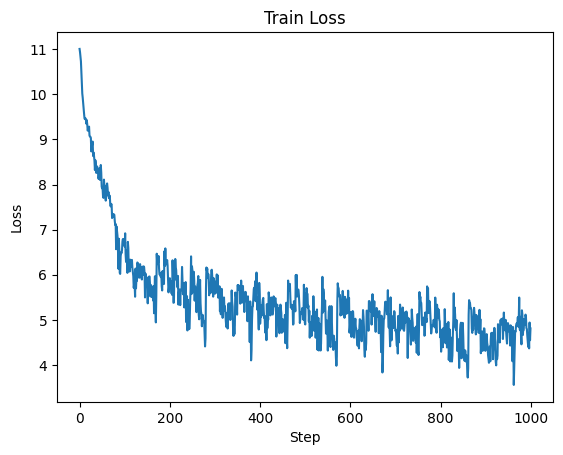

In [5]:
# plot the train loss
x = list(train_stats.keys())
x = sorted(x)
y = [train_stats[i]["train_loss"] for i in x]

plt.plot(x, y)
plt.title("Train Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()


Text(0.5, 1.0, 'Val Loss')

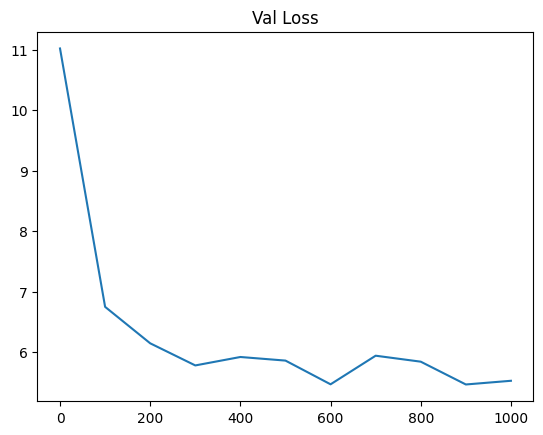

In [6]:
# plot the val loss
x = list(val_stats.keys())
x = sorted(x)
y = [val_stats[i]["val_loss"] for i in x]

plt.plot(x, y)
plt.title("Val Loss")

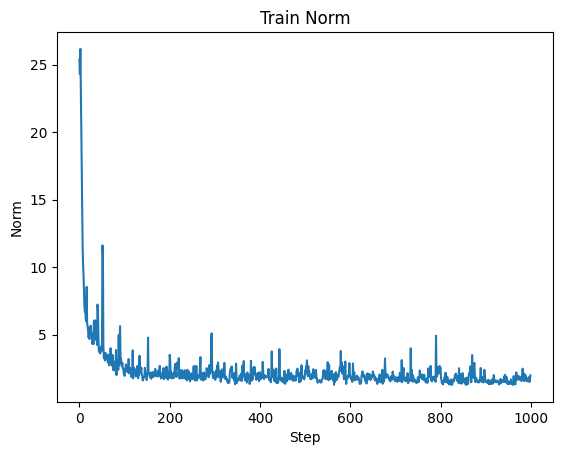

In [7]:
# plot train norm
x = list(train_stats.keys())
x = sorted(x)
y = [train_stats[i]["norm"] for i in x]
plt.plot(x, y)
plt.title("Train Norm")
plt.xlabel("Step")
plt.ylabel("Norm")
plt.show()

Average TPS: 648.96


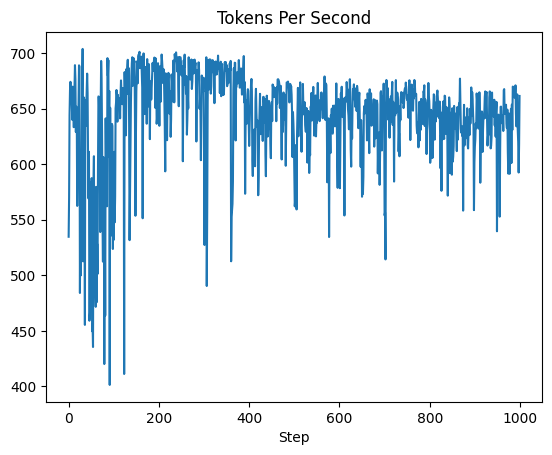

In [8]:
# plot tokens per second
x = list(train_stats.keys())
x = sorted(x)
y = [train_stats[i]["tokens_per_second"] for i in x]
plt.plot(x, y)
plt.title("Tokens Per Second")
plt.xlabel("Step")

# average TPS (excluding first 100 steps)
y = [train_stats[i]["tokens_per_second"] for i in x if i > 100]
mean_y = sum(y) / len(y)
print(f"Average TPS: {mean_y:.2f}")

In [9]:
# compare samples through time
for step in samples:
    print(f">>>Sample at step {step}:")
    print(samples[step])


>>>Sample at step 0:
<|endoftext|>ria courage163163163 Dougpsons impart harbour Snyderophonflation define HawTagTagMobileworks lust interested unintetermin Kremlin Latinos Ragefire Schemeの�cedovan arenas drains

>>>Sample at step 100:
<|endoftext|>.<|endoftext|>, him;
And to,
And, as of:
 the,
 me! me:
That a with of,?<|endoftext|>H

>>>Sample at step 200:
<|endoftext|>:
But,,, is see
But have<|endoftext|>I shall
WithThat'll be you are, but you,
To are thee?<|endoftext|>KING

>>>Sample at step 300:
<|endoftext|>First;
But that you to all;
And I had he is this time-What?
And she with one;
What doth I have

>>>Sample at step 400:
<|endoftext|> ELNORROMVOL, yet.<|endoftext|>R? I will IET:
If I, my life.<|endoftext|>ROMER:
No,
The soul

>>>Sample at step 500:
<|endoftext|>FLpherd, to the
That then I might;
Where I am the king;
Where
My lady is the
The
To hold the son

>>>Sample at step 600:
<|endoftext|>U MARESTERESUS:
WhIRZESeech it.<|endoftext|>OLIOL:
A good mother!
No more
So cannot

>>

In [10]:
# Let's load the model and sample from it
model, _ = model_cfg.get_model_and_optimizer(device="cpu")
model = load_model(str(Path(train_config.output_dir) / "model_s1000.pt"), device="cpu")
model.eval()

num decayed parameter tensors: 50, with 124,318,464 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
Using regular AdamW with fused=False
num decayed parameter tensors: 50, with 124,318,464 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
Using regular AdamW with fused=False


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x TransformerBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [11]:
tokenizer = model_cfg.get_tokenizer()


def sample_from_model(prompt: str) -> str:
    tokens = tokenizer.encode(prompt, add_eot=False)
    tokens = torch.tensor(tokens, dtype=torch.long)
    tokens = tokens.unsqueeze(0).repeat(1, 1)
    tokens = tokens.to("cpu")
    output = model.generate(tokens, max_new_tokens=100, end_token=tokenizer.eot_token)
    return tokenizer.decode(output[0].tolist())

In [13]:
print(sample_from_model("Romeo and Juliet"))

Romeo and Juliet
What fear! We are thou know me, my death. for thou woe, and so be but if thou shaltst never fly and talk Pray!<|endoftext|>
